In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from tqdm import *

In [2]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1133 non-null   int64  
 1   event                 1133 non-null   object 
 2   race                  1133 non-null   object 
 3   country               1133 non-null   object 
 4   participation         1133 non-null   object 
 5   distance              1133 non-null   float64
 6   elevation_gain        1133 non-null   float64
 7   elevation_loss        1133 non-null   float64
 8   aid_stations          1133 non-null   int64  
 9   participants          1133 non-null   int64  
 10  country_code          1133 non-null   object 
 11  year                  1133 non-null   int64  
 12  month                 1133 non-null   int64  
 13  day                   1133 non-null   int64  
 14  frequency_in_ranking  1133 non-null   int64  
 15  equivalent_distance  

In [3]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.loc[join.speed < 20]
join = join.loc[join.distance > 150]

In [4]:
join_unique = join.drop_duplicates(subset=['runner_id'])

In [5]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)
# join = join.loc[join.speed > 30]
# join = join.loc[join.equivalent_speed > 30]

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

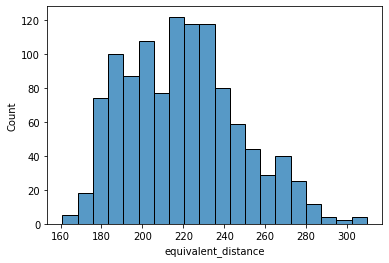

In [6]:
sns.histplot(
    x = race.equivalent_distance[race.distance > 150]
)

<AxesSubplot:xlabel='distance', ylabel='Count'>

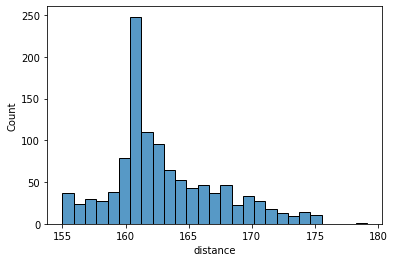

In [7]:
sns.histplot(
    x = race.distance[race.distance > 150]
)

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

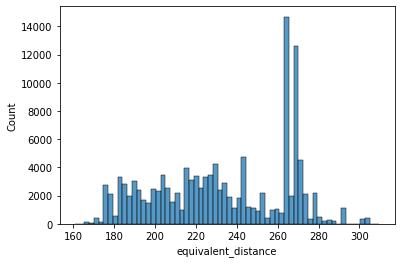

In [8]:
sns.histplot(
    x = join.equivalent_distance[join.equivalent_distance > 150]
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='Count'>

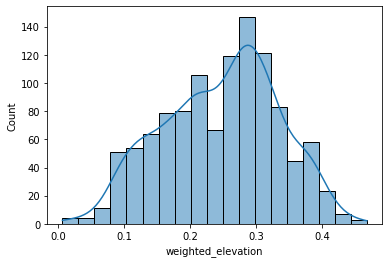

In [9]:
sns.histplot(
    x = race.weighted_elevation[race.distance > 150],
    kde = True
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='equivalent_distance'>

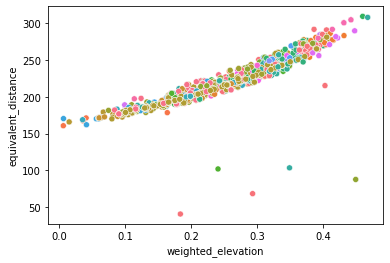

In [10]:
sns.scatterplot(
    x = "weighted_elevation",
    y = "equivalent_distance",
    data = race,
    hue = "country",
    legend = False
)

<AxesSubplot:xlabel='distance', ylabel='equivalent_distance'>

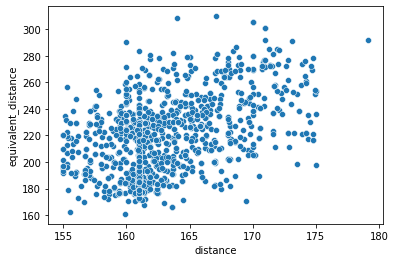

In [11]:
sns.scatterplot(
    x = "distance",
    y = "equivalent_distance",
    data = race[race.distance > 150]
    
)

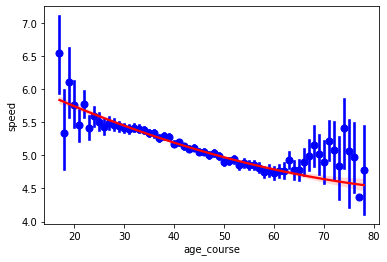

In [12]:
join = join.loc[join.speed < 20]
ax = sns.regplot(
    x = "age_course",
    y = "speed",
    data = join[join.distance > 150],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

<AxesSubplot:>

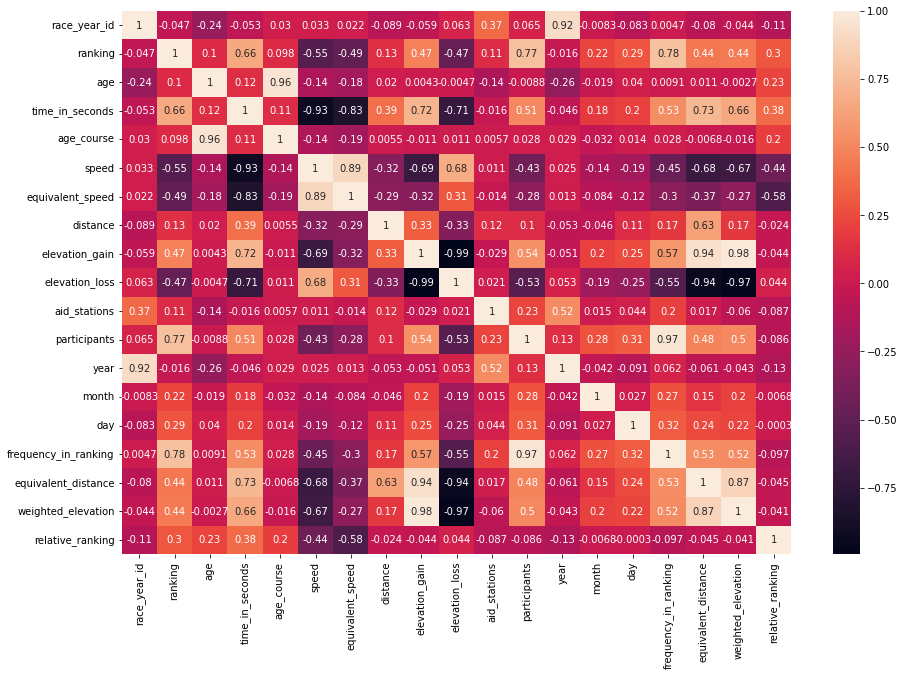

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(join.corr(), annot = True)

In [14]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112202 entries, 0 to 130136
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112202 non-null  int64         
 1   ranking               112202 non-null  float64       
 2   runner                112202 non-null  object        
 3   time                  112202 non-null  object        
 4   age                   112202 non-null  float64       
 5   gender                112174 non-null  object        
 6   nationality           112202 non-null  object        
 7   time_in_seconds       112202 non-null  float64       
 8   runner_id             112174 non-null  object        
 9   age_course            112202 non-null  float64       
 10  age_range             112202 non-null  category      
 11  speed                 112202 non-null  float64       
 12  equivalent_speed      112202 non-null  float64       
 13 

In [15]:
def homeCountry(df, th):
    '''
        :param df: join, merge de runners avec races
        :param th: threshold, nombre de courses minimales effectuées par les coureurs
    '''
    runners_occ = df['runner_id'].value_counts().fillna(0).astype(int)
    runners_occ = pd.DataFrame(runners_occ).reset_index()
    runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})
    
    pro_runners_id = runners_occ.loc[runners_occ.occ >= th]
    
    res = pd.DataFrame()
    
    for runner in tqdm(pro_runners_id.runner_id):
        runner_info = df.loc[(df.runner_id == runner)]
        
        res = res.append({'runner_id': runner,
                         'nationality': runner_info['nationality'].iloc[0],
                         'total_races': runner_info.shape[0],
                         'home_races': runner_info.loc[runner_info.country_code == runner_info['nationality']].shape[0],
                         'fore_races': runner_info.loc[runner_info.country_code != runner_info['nationality']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_races / res.total_races * 100
    )
    return res

In [16]:
res = homeCountry(join, 5)

100%|██████████████████████████████████████| 3247/3247 [00:17<00:00, 184.62it/s]


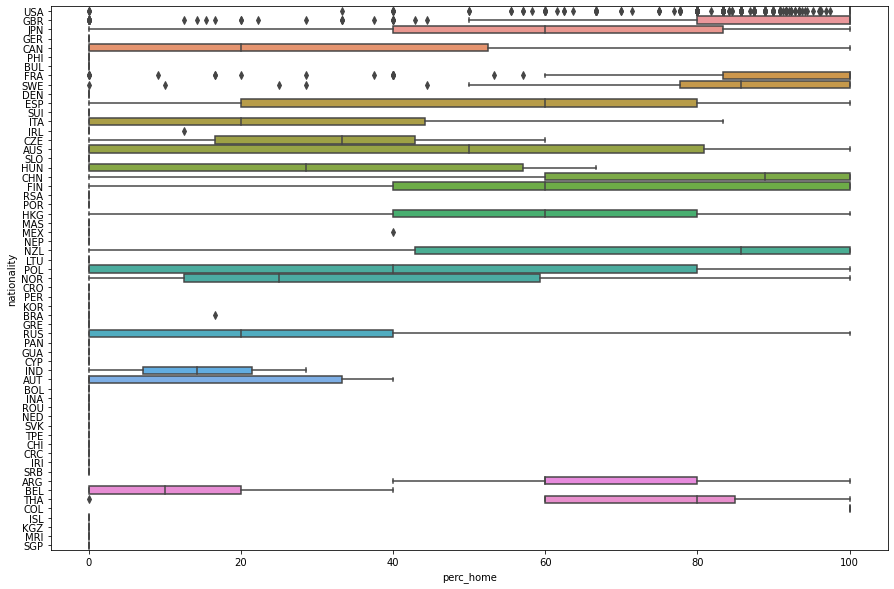

In [17]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "nationality",
    data = res
)
plt.savefig('percentage_home.pdf')

In [18]:
def homeRace(df):
    '''
        :param df: join, merge de runners avec races
    '''
    res = pd.DataFrame()
    
    for race in tqdm(df.race_year_id.unique()):
        runners_in_race = df.loc[(df.race_year_id == race)]
        
        res = res.append({'race_year_id': race,
                          'total_runners': runners_in_race.shape[0],
                          'home_runners': runners_in_race.loc[runners_in_race.nationality == runners_in_race['country_code']].shape[0],
                          'fore_runners': runners_in_race.loc[runners_in_race.nationality != runners_in_race['country_code']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_runners / res.total_runners * 100,
        perc_fore = res.fore_runners / res.total_runners * 100
    )
    return res

In [19]:
res2 = homeRace(join)

100%|██████████████████████████████████████| 1126/1126 [00:01<00:00, 783.59it/s]


In [20]:
new_race = pd.merge(race, res2, left_on="race_year_id", right_on="race_year_id", how="left")
new_race = new_race.dropna()

In [21]:
top_country_race = new_race.loc[(new_race.country_code == "USA") | (new_race.country_code == "GBR") |
                            (new_race.country_code == "FRA") | (new_race.country_code == "SWE") |
                            (new_race.country_code == "AUS") | (new_race.country_code == "CHN") |
                            (new_race.country_code == "CAN") | (new_race.country_code == "ESP") |
                            (new_race.country_code == "JPN") | (new_race.country_code == "POL") ]

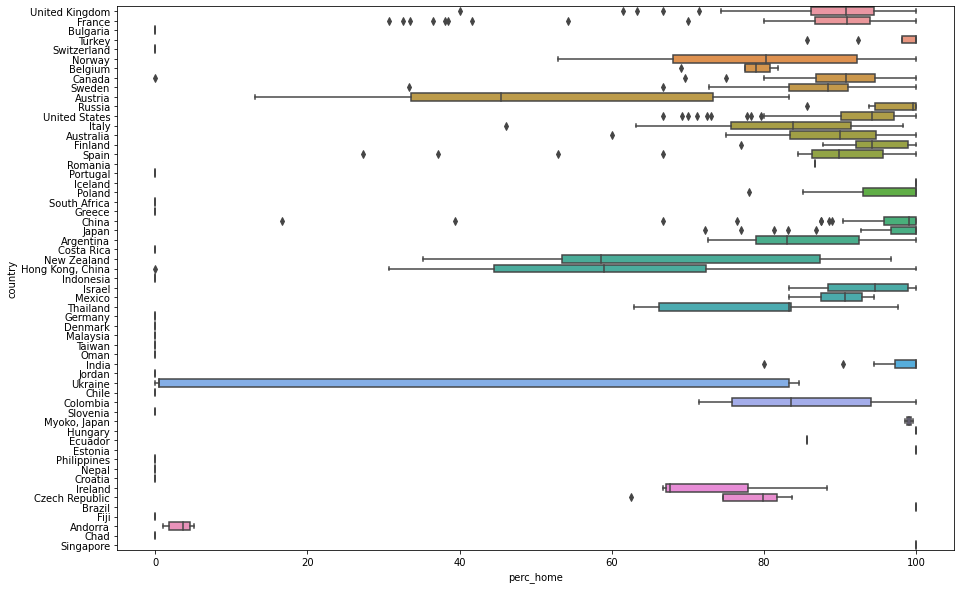

In [22]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "country",
    data = new_race
)
plt.savefig('percentage_home_race.pdf')

<AxesSubplot:xlabel='year', ylabel='perc_fore'>

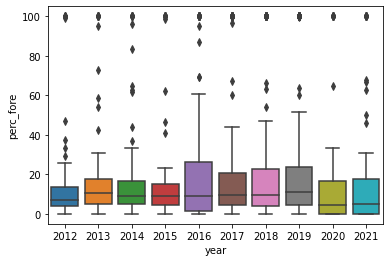

In [23]:
sns.boxplot(
    y = 'perc_fore',
    x = 'year',
    data = new_race
)


### Pourcentage d'étrangers moyens par course

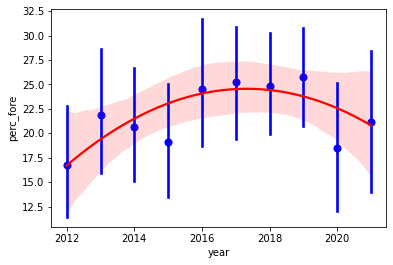

In [24]:
ax = sns.regplot(
    x = "year",
    y = "perc_fore",
    data = new_race,
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

plt.savefig('perc_foreigners_per_year.pdf')

<AxesSubplot:xlabel='country', ylabel='count'>

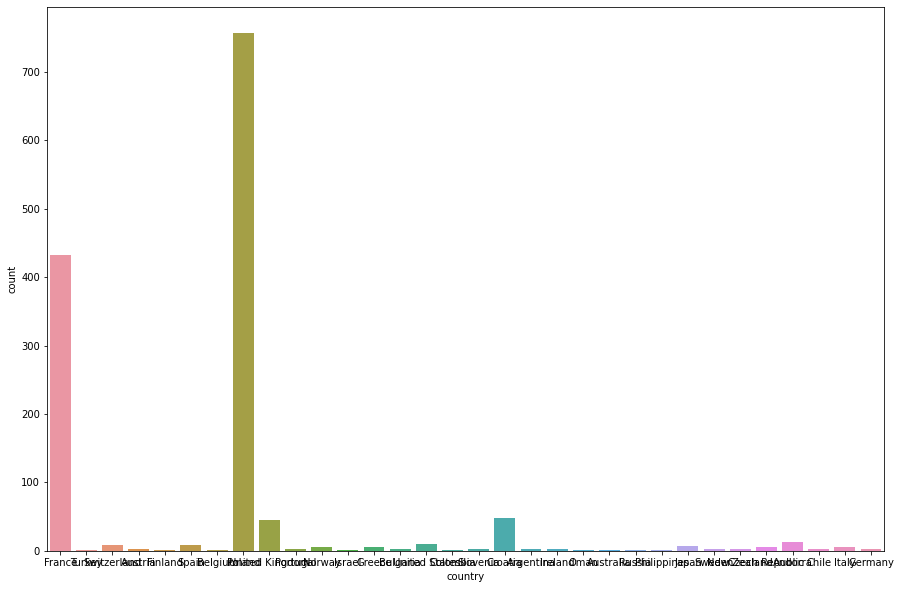

In [25]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.nationality == "POL"]
)

<AxesSubplot:xlabel='perc_fore', ylabel='country'>

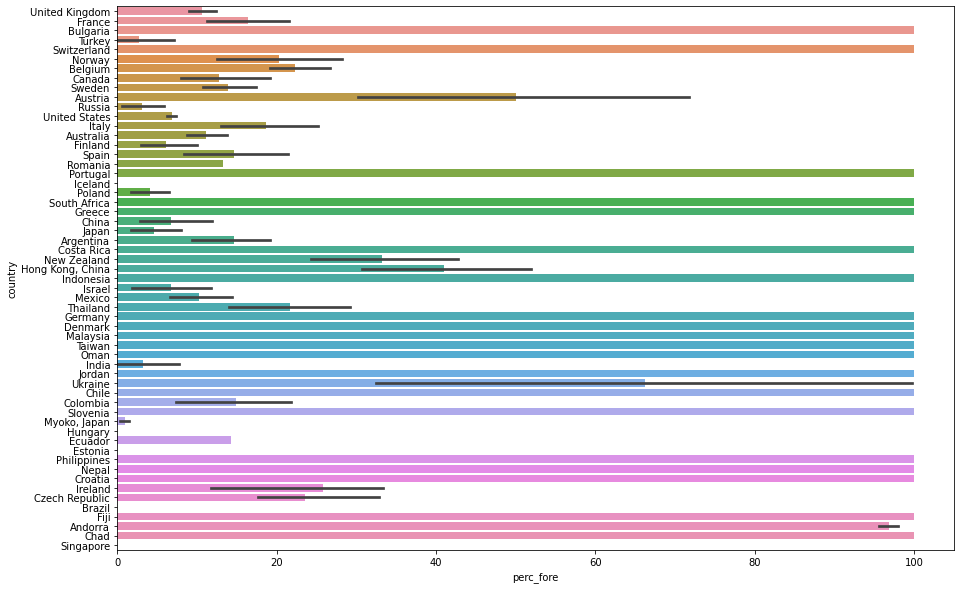

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(
    x = "perc_fore",
    y = "country",
    data = new_race
)

In [27]:
new_race[new_race.country_code == "FRA"].sort_values('perc_fore')

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,...,day,frequency_in_ranking,equivalent_distance,weighted_elevation,date,total_runners,home_runners,fore_runners,perc_home,perc_fore
137,50051,Infinity Trail Backyard - Normandie,Infinity Trail - 23 boucles,France,solo,155.30,5160.0,-5160.0,1,80,...,31,2,206.90,0.249396,2020-07-31,2.0,2.0,0.0,100.000000,0.000000
724,10563,GRAND TRAIL STEVENSON,GTS 3 jours - B,France,solo,156.20,5143.0,-5986.0,6,23,...,15,23,207.63,0.247700,2016-07-15,23.0,23.0,0.0,100.000000,0.000000
160,53283,LE DERNIER HOMME DEBOUT MORVAN,24 Boucles,France,solo,169.90,5740.0,-5740.0,1,350,...,25,6,227.30,0.252530,2020-01-25,6.0,6.0,0.0,100.000000,0.000000
500,31523,Les Traces du Nord Basse-Terre,L'Ultra-Trail®,France,solo,155.40,6290.0,-6300.0,14,400,...,16,10,218.30,0.288136,2018-02-16,10.0,10.0,0.0,100.000000,0.000000
1070,2871,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,France,solo,168.90,10982.0,-10952.0,0,1363,...,18,1363,278.72,0.394015,2012-10-18,1208.0,1167.0,41.0,96.605960,3.394040
2,69855,Grand Raid des Pyrénées,Ultra Tour 160,France,solo,167.00,9980.0,-9980.0,13,600,...,20,455,266.80,0.374063,2021-08-20,237.0,228.0,9.0,96.202532,3.797468
108,54013,SPARNATRAIL,P'tiot Sparnatrail,France,solo,33.30,750.0,-750.0,1,1800,...,10,693,40.80,0.183824,2019-11-10,693.0,661.0,32.0,95.382395,4.617605
128,61035,ULTRA 01,Ultra 165km,France,solo,167.20,7230.0,-7230.0,8,300,...,21,231,239.50,0.301879,2020-08-21,147.0,140.0,7.0,95.238095,4.761905
21,68778,Ultra Tour des 4 Massifs,Ut4M 160 Challenge,France,solo,173.10,11810.0,-11710.0,12,545,...,15,545,291.20,0.405563,2021-07-15,410.0,390.0,20.0,95.121951,4.878049
987,4870,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,France,solo,164.60,10100.0,-10060.0,0,1363,...,17,1363,265.60,0.380271,2013-10-17,1271.0,1205.0,66.0,94.807238,5.192762


In [28]:
new_race.loc[new_race.race_year_id == 11263]['year']

707    2016
Name: year, dtype: int64

In [29]:
French = join.loc[join.nationality == "FRA"]
runners_occ = French['runner_id'].value_counts().fillna(0).astype(int)
runners_occ = pd.DataFrame(runners_occ).reset_index()
runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})


pro_runners_id = runners_occ.loc[runners_occ.occ >= 10]
pro_runners_id

,runner_id,occ
0,JOUFFROYRomainFRAM43.0,16
1,GUILLONAntoineFRAM51.0,15
2,BALAHACHIRafionFRAM41.0,14
3,FRANCOISMatthiasFRAM44.0,12
4,LELEVETCyrilFRAM50.0,11
5,BETOURETSebastienFRAM44.0,11
6,DELIKATPatrickFRAM53.0,11
7,DHAENEFrancoisFRAM36.0,10
8,PAYENCharlesFRAM35.0,10
9,CALMETTESGuillaumeFRAM37.0,10


<AxesSubplot:xlabel='country', ylabel='count'>

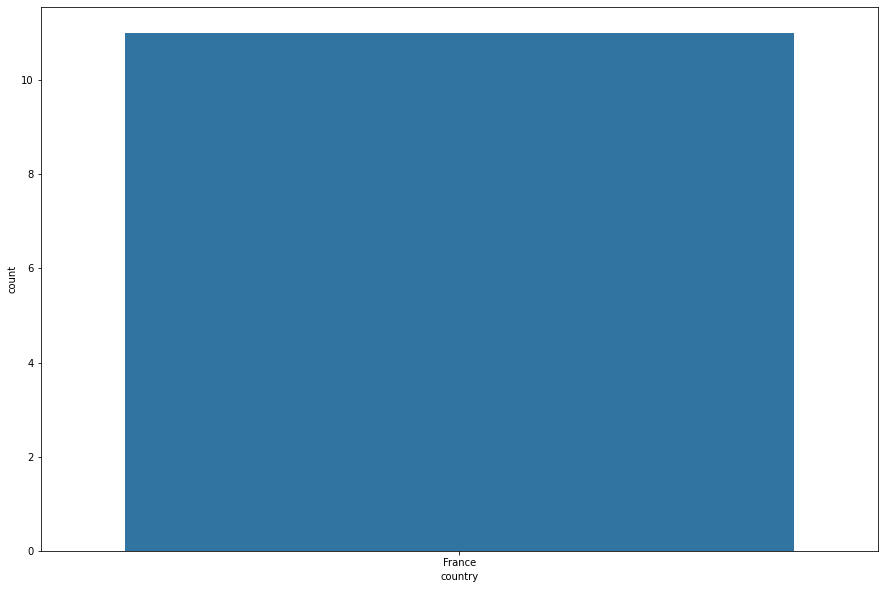

In [30]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.runner_id == 'LELEVETCyrilFRAM50.0']
)

In [31]:
count = 0
total_races = len(race)
for r in new_race.race_year_id.unique():
    country = join.loc[join.race_year_id == r].iloc[0].country_code
    nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
    if nat_first_df.shape[0] > 0:
        if country == nat_first_df.iloc[0]['nationality']:
            count += 1
    
print(f"{total_races=}")
print(f"{count=}")      

total_races=1133
count=844


In [32]:
def get_first_place_local_rate(join,new_race, pas):

    race_fore_decils = []
    race_perc_foreigners = []
    for i in np.arange(2 * pas,10, pas):
        race_fore_decils.append(new_race.loc[new_race.perc_fore >= i/10])
        race_perc_foreigners.append(i*10)
        
    perc_first_at_home = []
    for d in tqdm(race_fore_decils):
        count = 0
        total_races = len(d)
        for r in d.race_year_id.unique():
            country = join.loc[join.race_year_id == r].iloc[0].country_code
            nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
            if nat_first_df.shape[0] > 0:
                if country == nat_first_df.iloc[0]['nationality']:
                    count += 1

        perc_first_at_home.append(count / total_races * 100)

    df = pd.DataFrame({'race_perc_foreigner': race_perc_foreigners, 'perc_first_local': perc_first_at_home})

    return df

In [33]:
df = get_first_place_local_rate(join,new_race, 0.1)

100%|███████████████████████████████████████████| 98/98 [01:12<00:00,  1.36it/s]


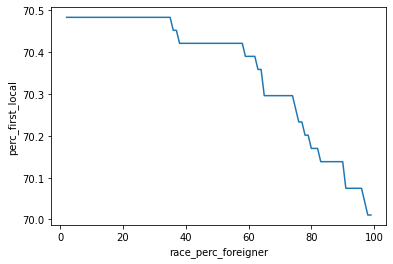

In [34]:
sns.lineplot(
    x = "race_perc_foreigner",
    y = "perc_first_local",
    data = df
)

plt.savefig('first_origin.pdf')

<AxesSubplot:xlabel='perc_fore'>

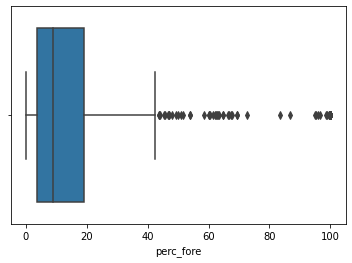

In [35]:
sns.boxplot(x = new_race.perc_fore)

In [36]:
def get_ranking_local_rate(join,new_race, max_relative_ranking = 1):
        
    new_race = new_race.loc[(new_race.perc_fore > 0) & (new_race.perc_fore < 100)]
    avg_local_runners_ranking_list = []
    avg_foreign_runners_ranking_list = []
    race_year_id_list = new_race.race_year_id.unique()
    for r in new_race.race_year_id.unique():
            ra = join.loc[(join.race_year_id == r)]
            country = ra.loc[ra.race_year_id == r].iloc[0].country_code
            avg_local_runners_ranking = ra.loc[(ra.nationality == country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()
            avg_foreign_runners_ranking = ra.loc[(ra.nationality != country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()

            avg_local_runners_ranking_list.append(avg_local_runners_ranking)
            avg_foreign_runners_ranking_list.append(avg_foreign_runners_ranking)
            race_perc_foreigner = new_race.perc_fore

    df = pd.DataFrame({'race_year_id': race_year_id_list,
                       'race_perc_foreigner': race_perc_foreigner,
                       'avg_local_runners_ranking': avg_local_runners_ranking_list,
                       'avg_foreign_runners_ranking': avg_foreign_runners_ranking_list
                      })

    return df.fillna(0)

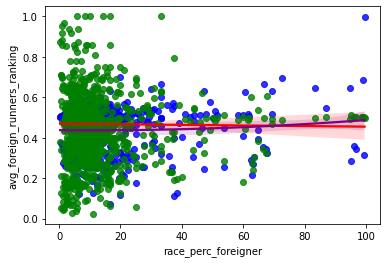

In [37]:
cdf = get_ranking_local_rate(join,new_race)
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_local_runners_ranking',
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    data = cdf
)
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_foreign_runners_ranking',
    scatter_kws={"color": "green"}, line_kws={"color": "purple"},
    data = cdf,
    order = 2
)

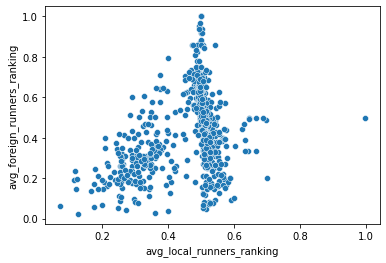

In [38]:
ax = sns.scatterplot(
    x = 'avg_local_runners_ranking',
    y = 'avg_foreign_runners_ranking',
    data = cdf,
    
)

In [39]:
join_cdf =  pd.merge(cdf, new_race, left_on="race_year_id", right_on="race_year_id", how="left")
join_cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 806
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   race_year_id                 807 non-null    int64         
 1   race_perc_foreigner          807 non-null    float64       
 2   avg_local_runners_ranking    807 non-null    float64       
 3   avg_foreign_runners_ranking  807 non-null    float64       
 4   event                        807 non-null    object        
 5   race                         807 non-null    object        
 6   country                      807 non-null    object        
 7   participation                807 non-null    object        
 8   distance                     807 non-null    float64       
 9   elevation_gain               807 non-null    float64       
 10  elevation_loss               807 non-null    float64       
 11  aid_stations                 807 non-null    

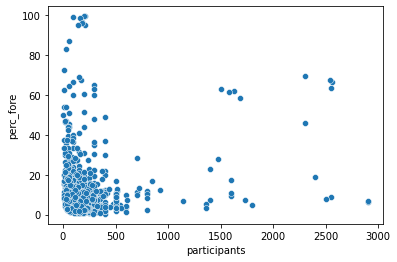

In [40]:
ax = sns.scatterplot(
    x = 'participants',
    y = 'perc_fore',
    #hue = "year",
    data = join_cdf
)

<AxesSubplot:>

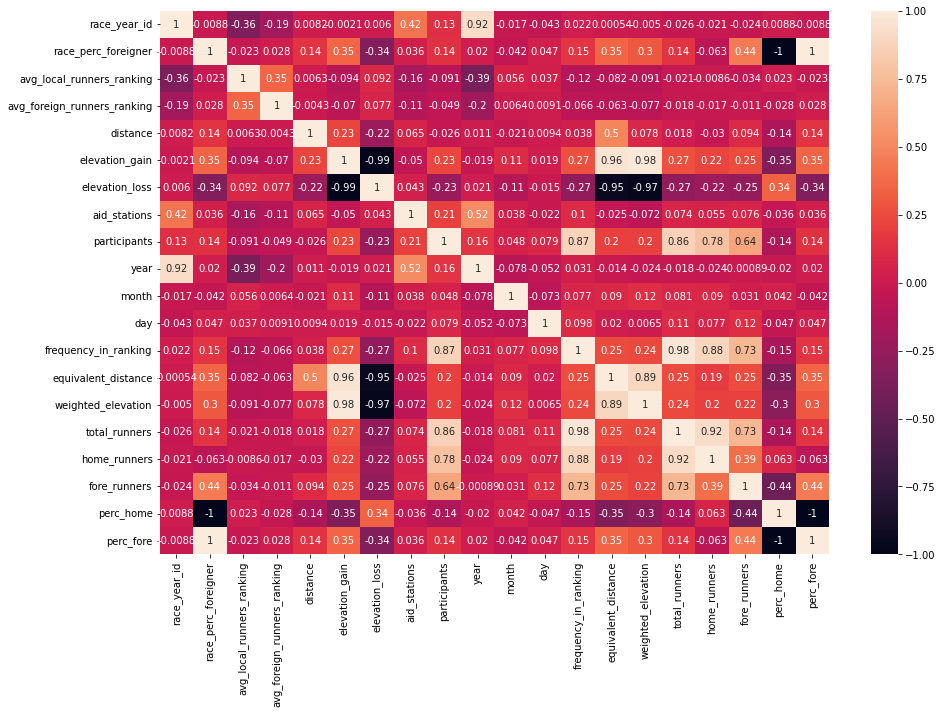

In [41]:
plt.figure(figsize=(15,10))
sns.heatmap(join_cdf.corr(), annot = True)

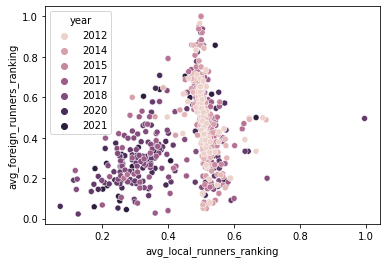

In [42]:
ax = sns.scatterplot(
    x = 'avg_local_runners_ranking',
    y = 'avg_foreign_runners_ranking',
    hue = "year",
    data = join_cdf
)

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

In [44]:
df = join_cdf[['avg_local_runners_ranking','avg_foreign_runners_ranking']]

In [45]:
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = df.index,
    index = df.index
)

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

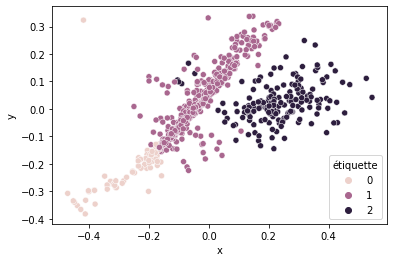

In [46]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=3
).fit(X)
labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)



df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette":labels})

sns.scatterplot("x", "y", hue="étiquette", data=df)

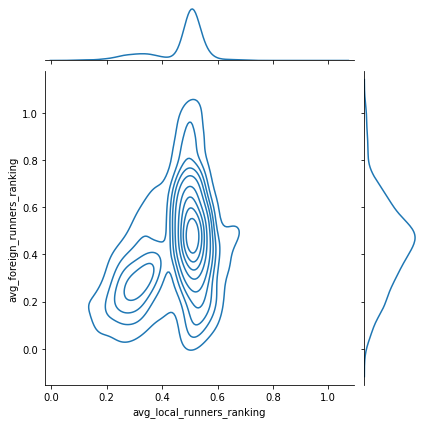

In [47]:
ax = sns.jointplot(
    x = 'avg_local_runners_ranking',
    y = 'avg_foreign_runners_ranking',
    #hue = "label",
    data = join_cdf,
    kind = 'kde'
)

In [48]:
join_cdf = join_cdf.assign(
    label = labels
)

In [49]:
join_cdf.loc[join_cdf.label == 0, "label"] = 1

<AxesSubplot:>

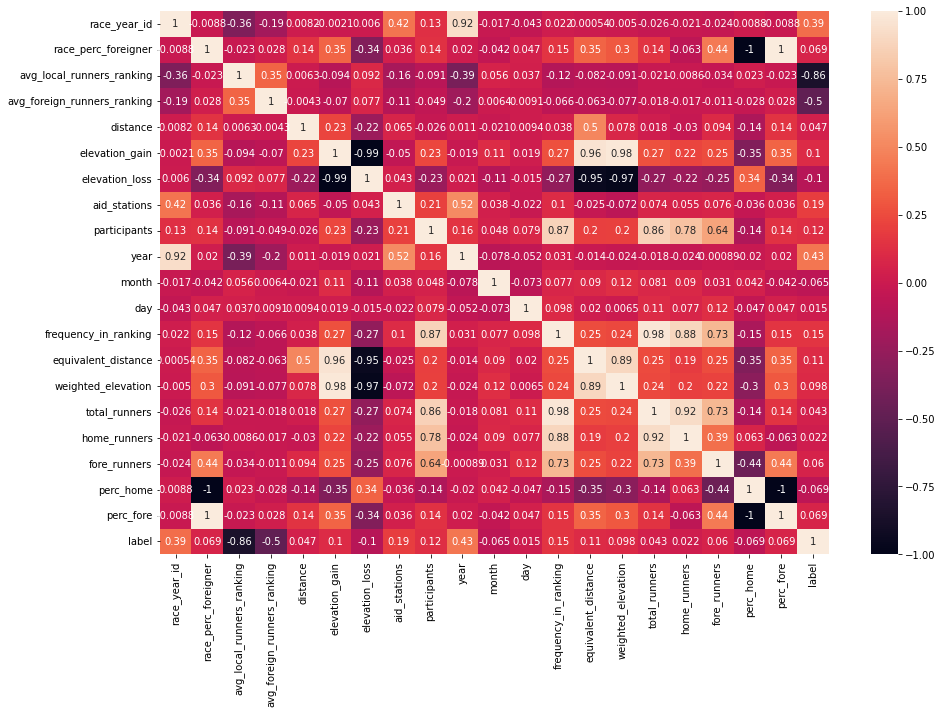

In [50]:
plt.figure(figsize=(15,10))
sns.heatmap(join_cdf.corr(), annot = True)

<AxesSubplot:xlabel='label', ylabel='avg_local_runners_ranking'>

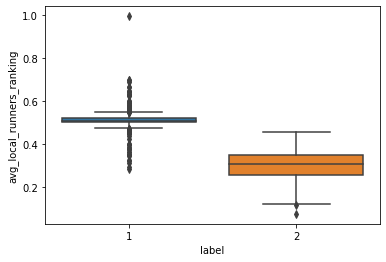

In [51]:
sns.boxplot(
    y = 'avg_local_runners_ranking',
    x = 'label',
    data = join_cdf
)


<AxesSubplot:xlabel='label', ylabel='avg_foreign_runners_ranking'>

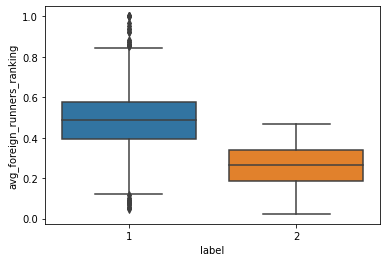

In [52]:
sns.boxplot(
    y = 'avg_foreign_runners_ranking',
    x = 'label',
    data = join_cdf
)


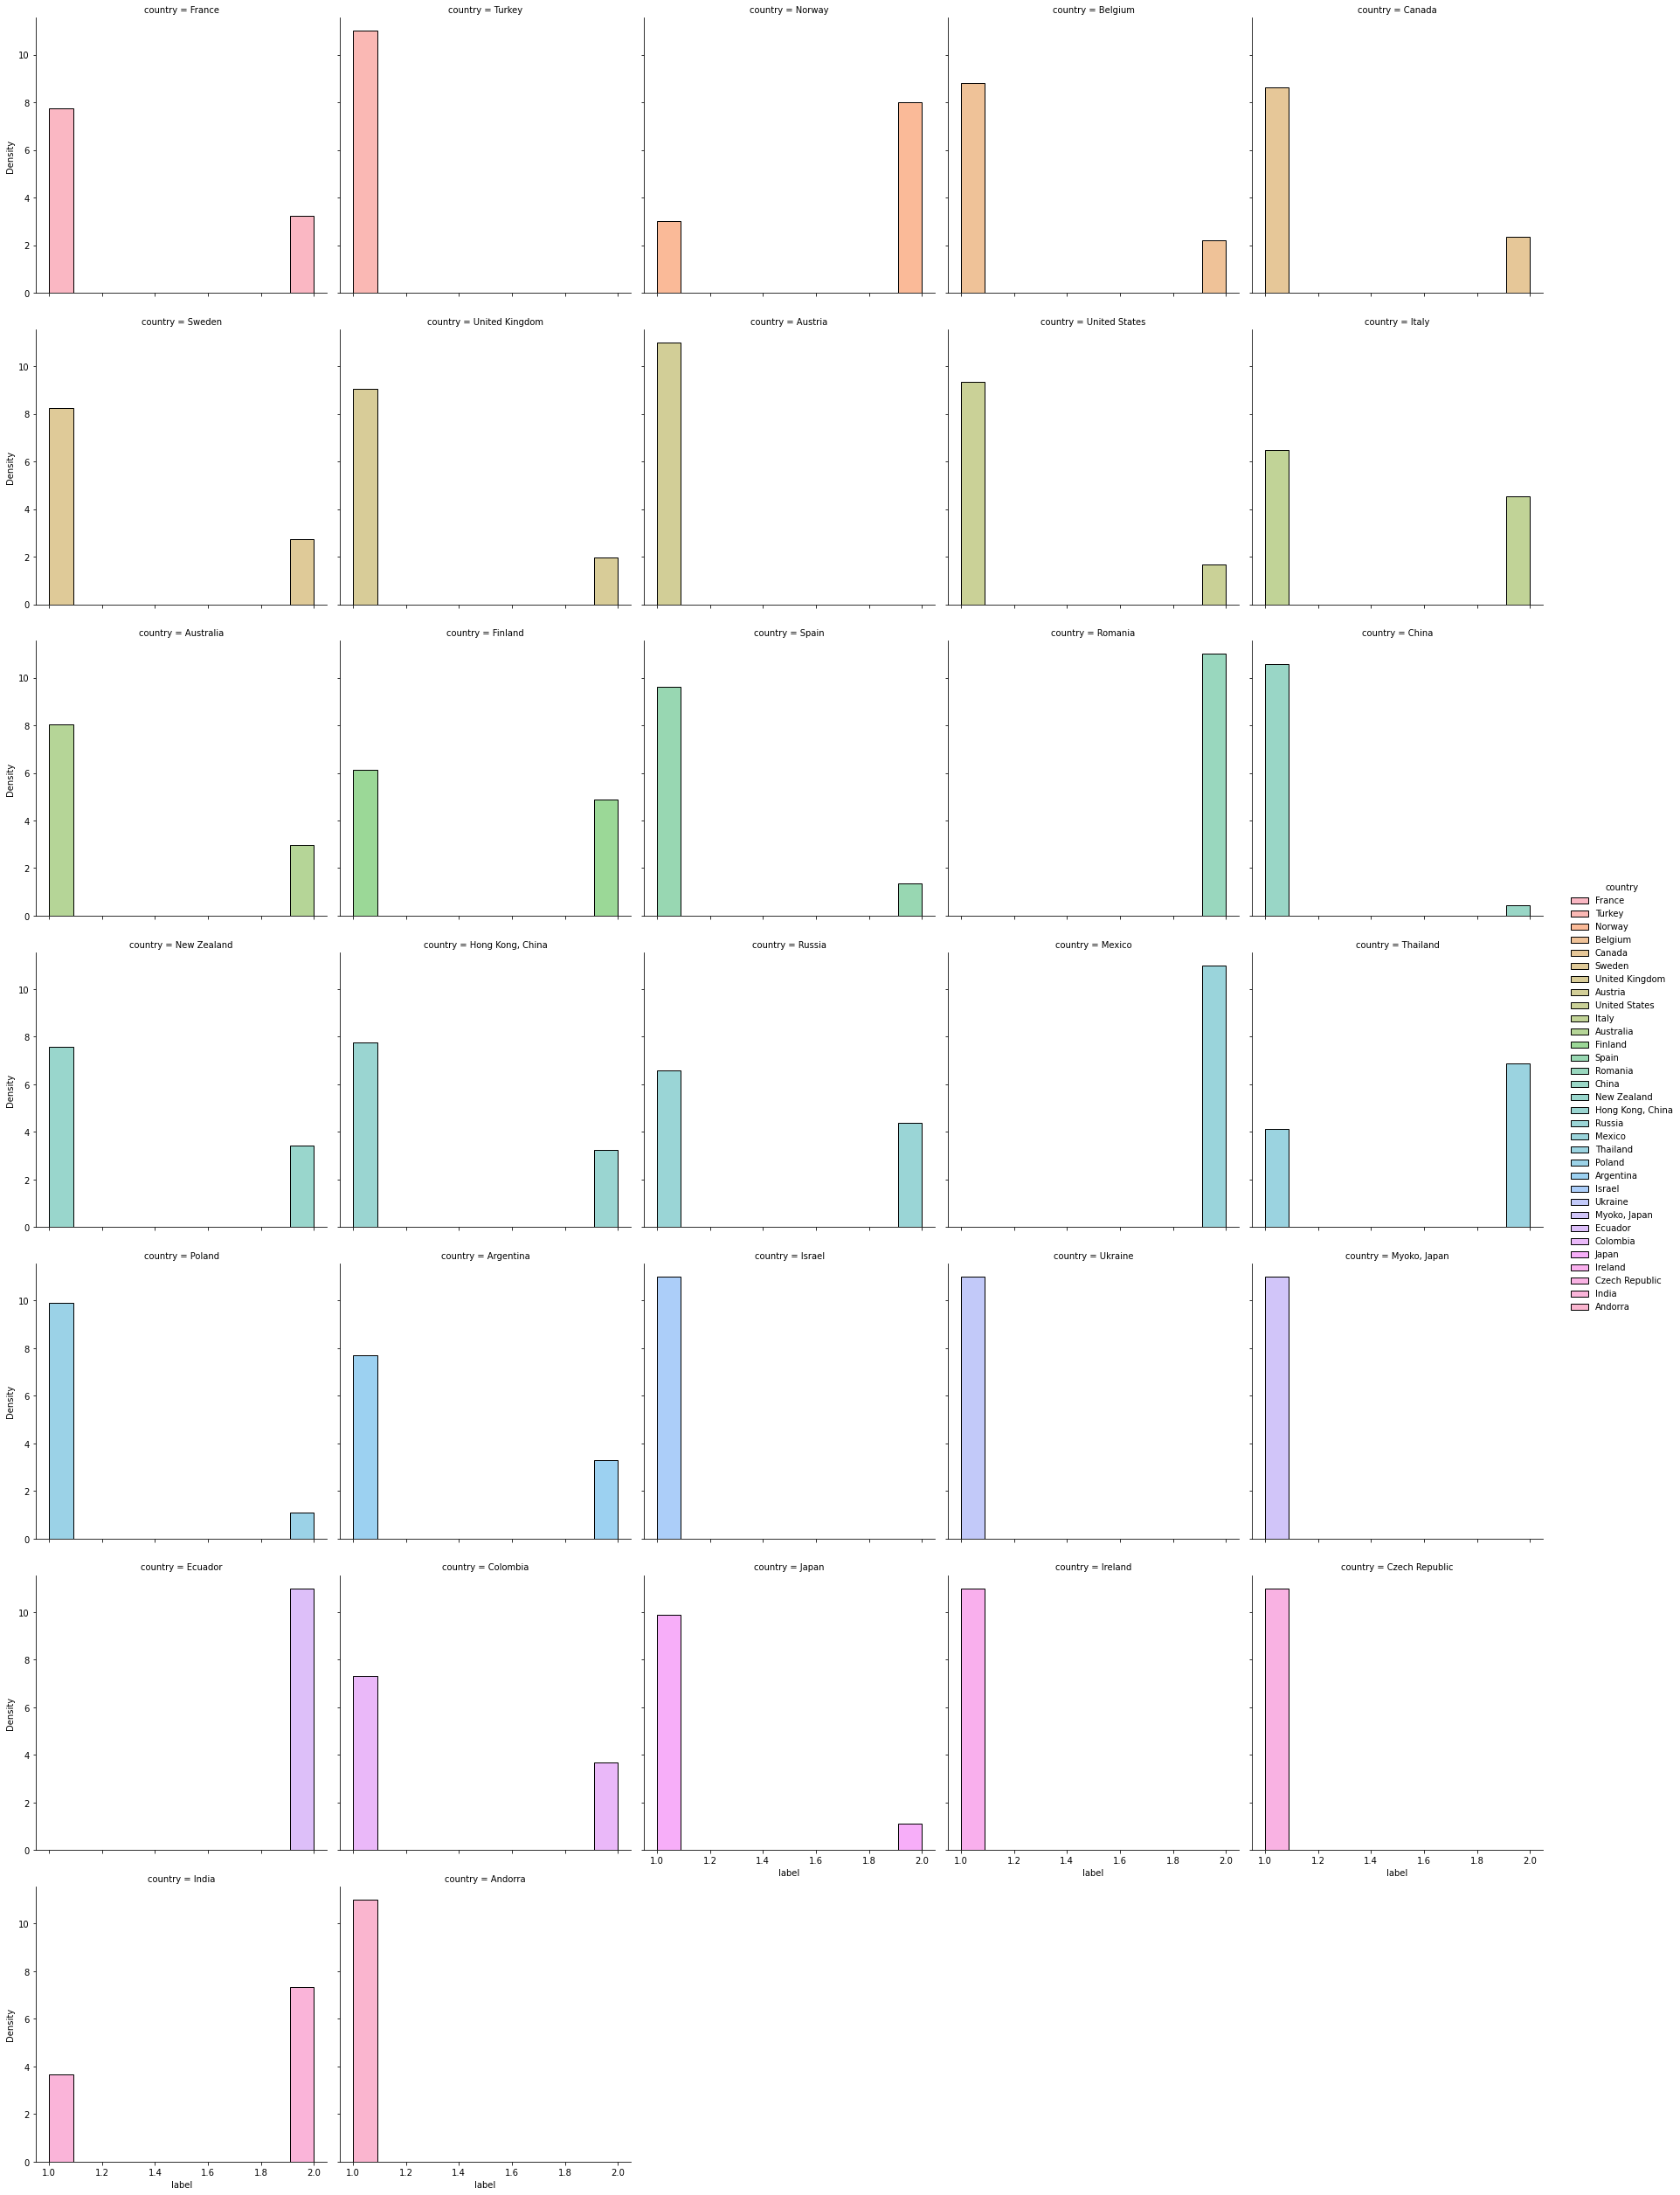

In [53]:
ax = sns.displot(x = join_cdf['label'], col=join_cdf['country'],col_wrap = 5,
                 hue=join_cdf['country'], stat = 'density', common_norm=False)

plt.savefig('../../../output/relation.pdf')

Index(['aid_stations', 'equivalent_distance', 'weighted_elevation',
       'total_runners', 'perc_home', 'perc_fore', 'label'],
      dtype='object')


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

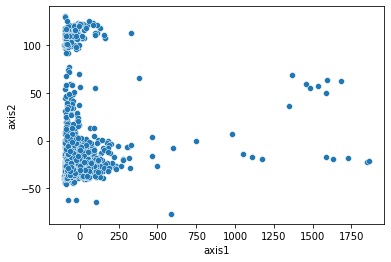

In [229]:
from sklearn.preprocessing import StandardScaler

df = new_race.drop(columns=['race_year_id','event','race','country','participation','country_code','date',
                           'elevation_gain','elevation_loss','frequency_in_ranking','participants',
                           'year','month','day','distance','home_runners','fore_runners'])
print(df.columns)

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['country'] = race.country
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2", data = X)

#plt.savefig('acp_on_all_races.pdf')

In [202]:
cls.explained_variance_ratio_

array([9.32356919e-01, 5.06100295e-02, 1.57722690e-02, 1.26067714e-03,
       7.30465482e-08])

<AxesSubplot:>

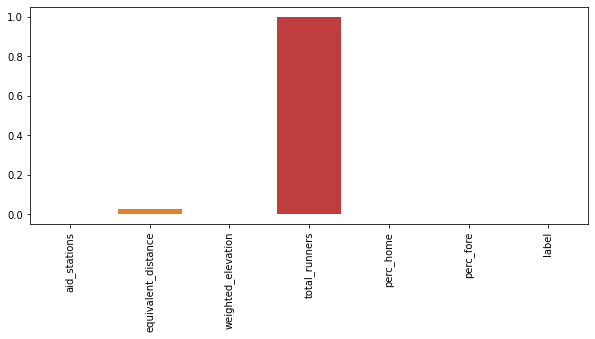

In [203]:
plt.figure(figsize=(10,4))
plt.xticks(rotation = 'vertical')
sns.barplot(x = df.columns.tolist(), y = cls.components_[0] )

<AxesSubplot:>

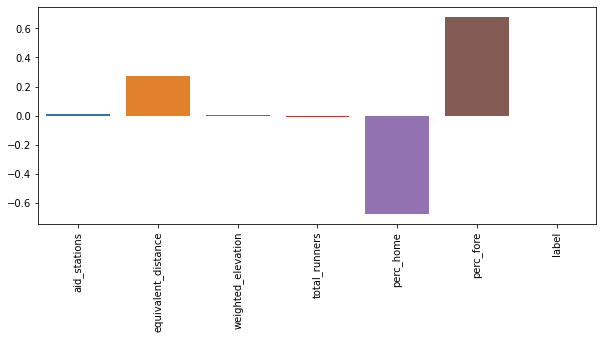

In [204]:
plt.figure(figsize=(10,4))
plt.xticks(rotation = 'vertical')
sns.barplot(x = df.columns.tolist(), y = cls.components_[1] )

In [210]:
df = new_race.drop(columns=['race_year_id','event','race','country','participation','country_code','date',
                           'elevation_gain','elevation_loss','frequency_in_ranking','participants',
                           'year','month','day','distance','home_runners','fore_runners'])

In [211]:
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = new_race.race_year_id,
    index = new_race.race_year_id
)

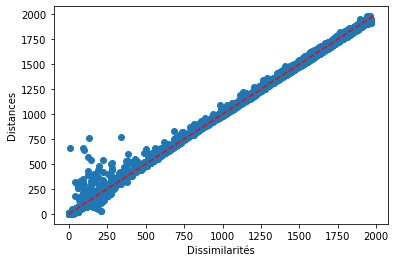

In [212]:
aftd = MDS(n_components=3, dissimilarity='precomputed')
dist = aftd.fit_transform(X)
plot_Shepard(aftd)
plt.show()

In [144]:
def plot_Shepard(mds_model, plot=True):
    """Affiche le diagramme de Shepard et retourne un couple contenant les
    dissimilarités originales et les distances apprises par le
    modèle.
    """

    assert isinstance(mds_model, MDS)

    # Inter-distances apprises
    dist = cdist(mds_model.embedding_, mds_model.embedding_)
    idxs = np.tril_indices_from(dist, k=-1)
    dist_mds = dist[idxs]

    # Inter-distances d'origine
    dist = mds_model.dissimilarity_matrix_
    dist_orig = dist[idxs]

    dists = np.column_stack((dist_orig, dist_mds))

    if plot:
        f, ax = plt.subplots()
        range = [dists.min(), dists.max()]
        ax.plot(range, range, 'r--')
        ax.scatter(*dists.T)
        ax.set_xlabel('Dissimilarités')
        ax.set_ylabel('Distances')

    return (*dists.T,)

In [148]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)

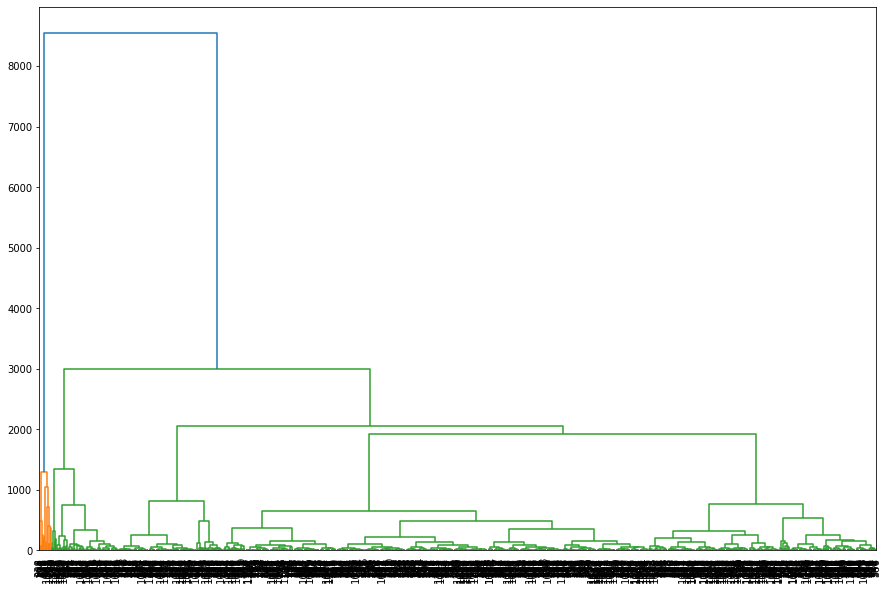

<Figure size 432x288 with 0 Axes>

In [226]:
plt.figure(figsize=(15,10))
cls = AgglomerativeClustering(
    affinity="euclidean", linkage="ward", distance_threshold=0, n_clusters=None
)
cls.fit(df)
plot_dendrogram(cls)
plt.show()

plt.savefig("CAH_dendogram.pdf")

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


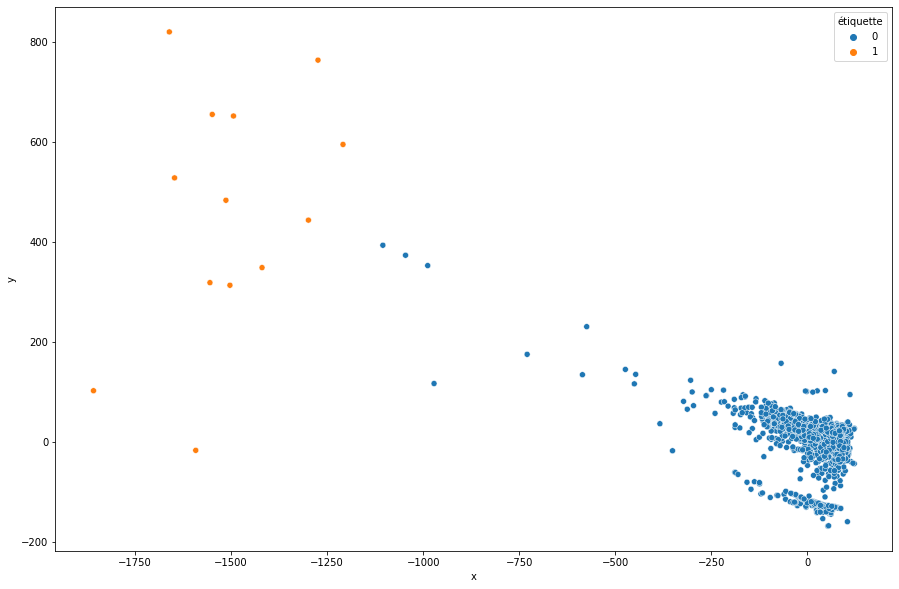

<Figure size 432x288 with 0 Axes>

In [227]:
plt.figure(figsize=(15,10))

model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=2
).fit(X)

labels = model.labels_
aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette": labels})

sns.scatterplot("x", "y", hue="étiquette", data=df)
plt.show()

plt.savefig("MDS_agglo_clus.pdf")

In [157]:
new_race = new_race.assign(
    label = labels
)

<AxesSubplot:>

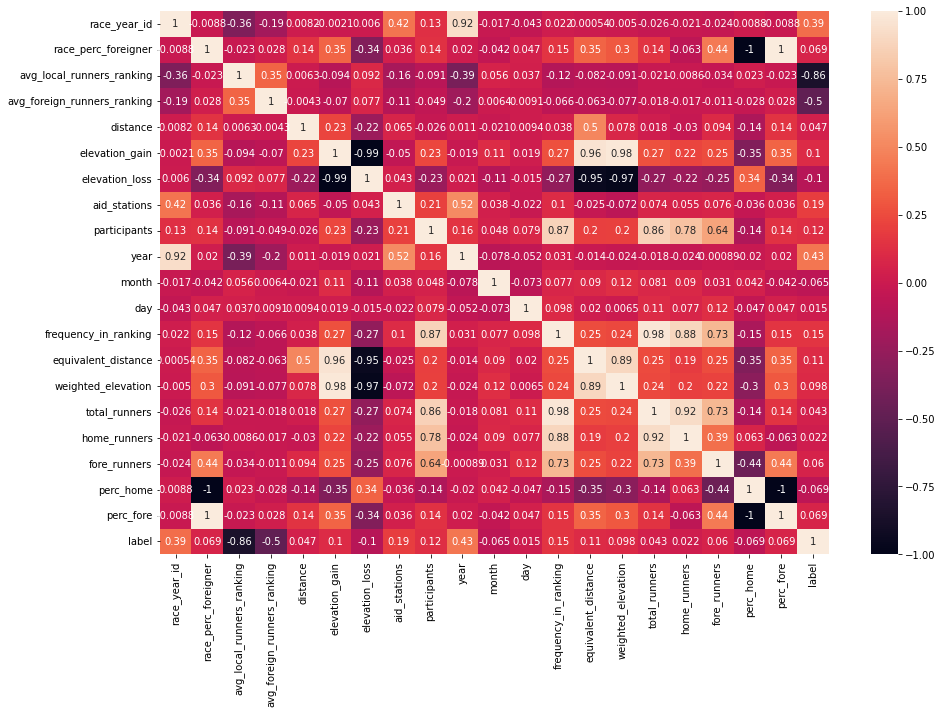

In [158]:
plt.figure(figsize=(15,10))
sns.heatmap(join_cdf.corr(), annot = True)

# KMEANS

In [215]:
df = new_race.drop(columns=['race_year_id','event','race','country','participation','country_code','date',
                           'elevation_gain','elevation_loss','frequency_in_ranking','participants',
                           'year','month','day','distance','home_runners','fore_runners'])

In [185]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

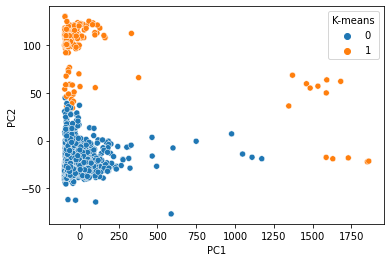

In [217]:
from sklearn.cluster import KMeans
# 2 groupements
cls = KMeans(n_clusters=2, init="k-means++")
cls.fit(StandardScaler().fit_transform(df))
labels = pd.Series(cls.labels_, name="K-means")
scatterplot_pca(data=df, hue=labels)
plt.show()

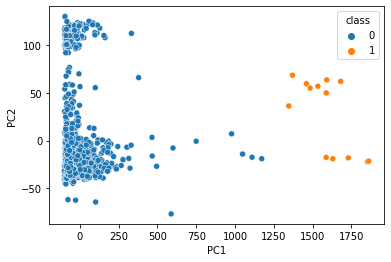

In [223]:
from sklearn.cluster import KMeans
# 2 groupements
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=2
).fit(X)

labels = model.labels_
scatterplot_pca(data=df, hue=labels)

plt.savefig("MDS_agglo_clus_PCA.pdf")
plt.show()

In [219]:
new_race = new_race.assign(
    label = labels
)

<AxesSubplot:>

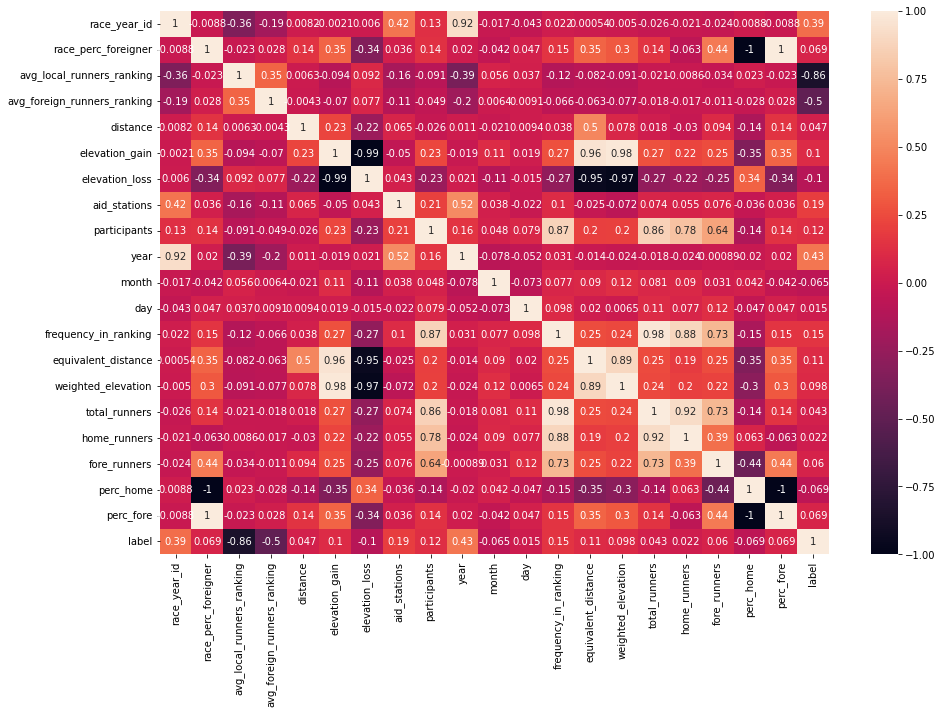

In [220]:
plt.figure(figsize=(15,10))
sns.heatmap(join_cdf.corr(), annot = True)

In [221]:
AN = new_race.loc[new_race.label == 1]

In [222]:
AN

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,...,frequency_in_ranking,equivalent_distance,weighted_elevation,date,total_runners,home_runners,fore_runners,perc_home,perc_fore,label
1,72496,UTMB®,UTMB®,France,solo,170.7,9930.0,-9930.0,11,2300,...,1526,270.00,0.367778,2021-08-27,1445.0,783.0,662.0,54.186851,45.813149,1
196,48019,Le Grand Raid De La Réunion,La Diagonale Des Fous,France,solo,168.1,9610.0,-9560.0,15,2900,...,2716,264.20,0.363740,2019-10-17,1952.0,1827.0,125.0,93.596311,6.403689,1
240,39881,UTMB®,UTMB®,France,solo,170.7,9930.0,-9930.0,16,2549,...,2549,270.00,0.367778,2019-08-30,1559.0,569.0,990.0,36.497755,63.502245,1
382,30965,Le Grand Raid De La Réunion,La Diagonale Des Fous,France,solo,168.1,9610.0,-9560.0,17,2900,...,2660,264.20,0.363740,2018-10-18,1961.0,1825.0,136.0,93.064763,6.935237,1
417,25073,UTMB®,UTMB®,France,solo,170.0,9990.0,-9990.0,16,2565,...,2565,269.90,0.370137,2018-08-31,1780.0,597.0,1183.0,33.539326,66.460674,1
537,20273,Grand Raid De La Réunion,La Diagonale Des Fous,France,solo,164.9,10000.0,-9960.0,18,2548,...,2548,264.90,0.377501,2017-10-19,1829.0,1671.0,158.0,91.361400,8.638600,1
572,17383,UTMB®,UTMB®,France,solo,168.6,9980.0,-9980.0,16,2542,...,2542,268.40,0.371833,2017-09-01,1690.0,550.0,1140.0,32.544379,67.455621,1
675,15338,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,France,solo,167.5,10100.0,-10060.0,0,2500,...,1688,268.50,0.376164,2016-10-20,1686.0,1556.0,130.0,92.289442,7.710558,1
707,11263,UTMB®,UTMB®,France,solo,171.0,10080.0,-10080.0,16,2300,...,1469,271.80,0.370861,2016-08-26,1469.0,451.0,1018.0,30.701157,69.298843,1
780,9086,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,France,solo,160.8,10410.0,-10360.0,0,1729,...,1729,264.90,0.392978,2015-10-22,1729.0,1598.0,131.0,92.423366,7.576634,1
